### Packages

In [45]:
import folium 
import mapclassify
import pickle
import time
from esda.moran import Moran
from libpysal.weights import Queen, KNN, W
import seaborn as sb
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from clustergram import Clustergram
from sklearn.preprocessing import scale
from sklearn.preprocessing import robust_scale
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.stats import kruskal
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed
from multiprocessing.pool import ThreadPool 

### Data

In [2]:
# load the completed clustergrams
# save cgrams
with open('clustergram_kmeans.pickle','rb') as f:
    cgram_kmeans = pickle.load(f)

with open('clustergram_gmm.pickle','rb') as f:
    cgram_gmm = pickle.load(f)

c:\Users\Gebruiker\anaconda3\envs\ssml\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator PCA from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
# Main gdf
popgridmanchester = gpd.read_file("popgridmanchesterlatest.gpkg")

# Subset of variables of interest
popgridsub = popgridmanchester.iloc[:,[4,11,18,21,22,25,27,30,31]+list(range(36,60))]

# Variables of interest
cluster_variables = [col for col in popgridsub.columns if col != "geometry"]

# Converting pop density to per km^2, will do this for the main gdf
popgridsub.buffer_pop_density = popgridsub.buffer_pop_density*1000000

# Remove nans and inf values, resetting index
popgridsub = popgridsub.replace([np.inf, -np.inf], np.nan)
popgridsub = popgridsub.dropna()
popgridsub = popgridsub.reset_index()

# Scaling due to the range of values differing between variables
popgridsub_scaled = scale(popgridsub[cluster_variables])

c:\Users\Gebruiker\anaconda3\envs\ssml\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [126]:
# subset without network variables
popgridsub2 = popgridsub.iloc[:,[1,2]+list(range(10,34))]
cluster_variables2 = [col for col in popgridsub2.columns if col != "geometry"]
popgridsub_scaled2 = scale(popgridsub2[cluster_variables2])

In [14]:
# subset with only network variables
popgridsub3 = popgridsub.iloc[:,list(range(1,10))+[33]]
cluster_variables3 = [col for col in popgridsub3.columns if col != "geometry"]
popgridsub_scaled3 = scale(popgridsub3[cluster_variables3])

In [4]:
# health data
healthdata = gpd.read_file("Greater_Manchester_NH_GIS.gpkg")

### K-means clustering with clustergram

In [116]:
# Using clustergram with k-means clustering up to 20 clusters
cgram_kmeans = Clustergram(range(2, 21), n_init=25, method='kmeans')

start_time = time.time()

#fit model
cgram_kmeans.fit(popgridsub_scaled)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

K=2 fitted in 3.015737771987915 seconds.
K=3 fitted in 3.1372413635253906 seconds.
K=4 fitted in 11.296127796173096 seconds.
K=5 fitted in 9.484164714813232 seconds.
K=6 fitted in 8.4657142162323 seconds.
K=7 fitted in 10.196593999862671 seconds.
K=8 fitted in 10.518393993377686 seconds.
K=9 fitted in 13.271138906478882 seconds.
K=10 fitted in 13.662186861038208 seconds.
K=11 fitted in 14.869878053665161 seconds.
K=12 fitted in 14.718684434890747 seconds.
K=13 fitted in 18.390925884246826 seconds.
K=14 fitted in 19.204128742218018 seconds.
K=15 fitted in 23.387380123138428 seconds.
K=16 fitted in 19.221139669418335 seconds.
K=17 fitted in 20.280039310455322 seconds.
K=18 fitted in 22.327308416366577 seconds.
K=19 fitted in 22.792728900909424 seconds.
K=20 fitted in 26.26741313934326 seconds.
Execution time: 284.52376914024353 seconds


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

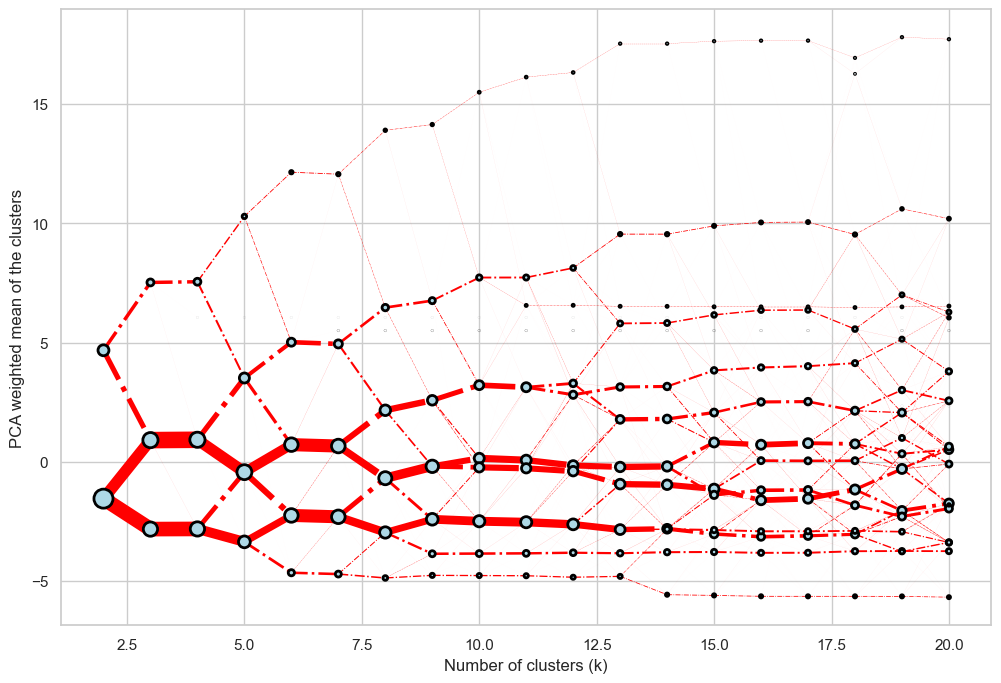

In [117]:
# plot cgram
sb.set(style='whitegrid')

cgram_kmeans.plot(
    size=0.5,
    linewidth=0.5,
    cluster_style={"color": "lightblue", "edgecolor": "black"},
    line_style={"color": "red", "linestyle": "-."},
    figsize=(12, 8)
)

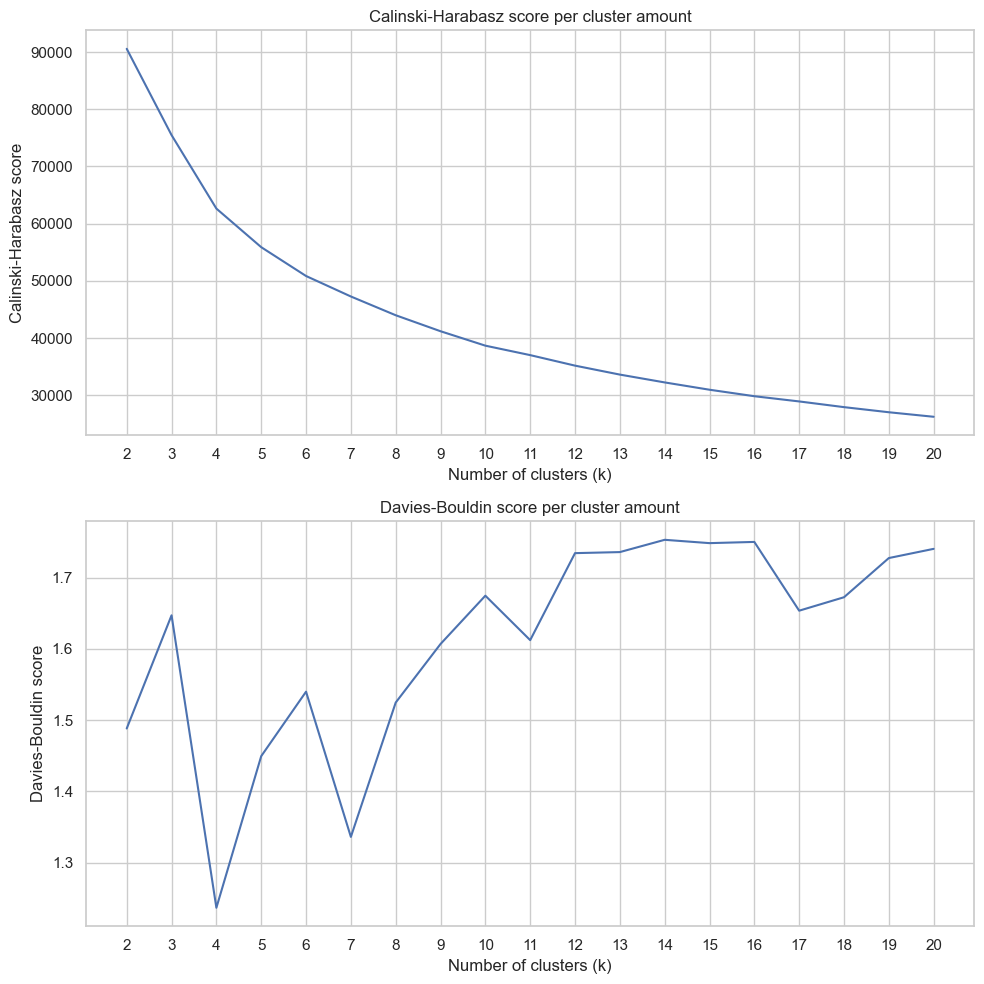

In [118]:
# Goodness of fit tests for the amount of clusters
# We use the Davies-Bouldin and Calinski-Harabasz scores, higher is better for both

# Calinski-Harabasz score: the within-cluster variance divided by the between-cluster variance.
# Davies-Bouldin score: The score is defined as the average similarity measure of each cluster with its most similar cluster, 
#  where similarity is the ratio of within-cluster distances to between-cluster distances. 
#  Thus, clusters which are farther apart and less dispersed will result in a better score.

# getting the scores
kmeansch = cgram_kmeans.calinski_harabasz_score()
kmeansdb = cgram_kmeans.davies_bouldin_score()

# Plotting both the Silhouette score and the Calinski-Harabasz score per cluster amount
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(K, kmeansch)
axs[0].set_xlabel("Number of clusters (k)")
axs[0].set_ylabel("Calinski-Harabasz score")
axs[0].grid(True)
axs[0].set_xticks(range(2,21))
axs[0].set_title('Calinski-Harabasz score per cluster amount')
axs[1].plot(K, kmeansdb)
axs[1].set_xlabel("Number of clusters (k)")
axs[1].set_ylabel("Davies-Bouldin score")
axs[1].grid(True)
axs[1].set_xticks(range(2,21))
axs[1].set_title('Davies-Bouldin score per cluster amount')
plt.tight_layout()
plt.show()

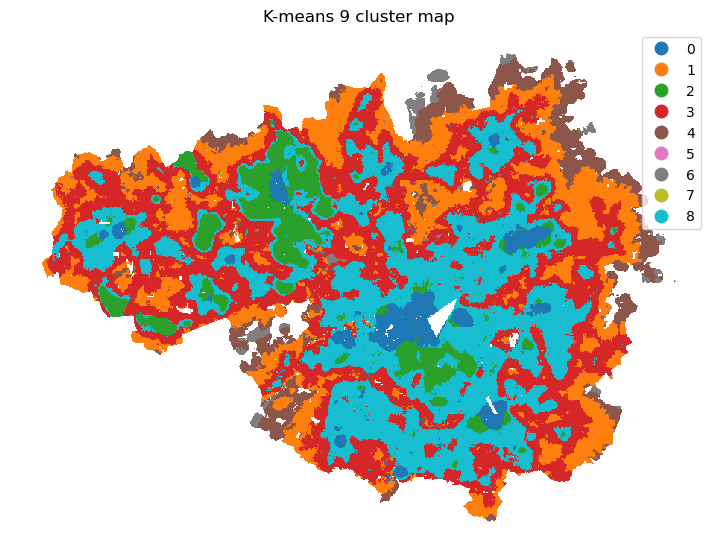

In [5]:
# Plotting results, 9 clusters
popgridsub["Kmeans_cluster_label"] = cgram_kmeans.labels[9]
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="Kmeans_cluster_label",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.title("K-means 9 cluster map")
plt.show()

### Gaussian mixture model with clustergram

In [97]:
# Using clustergram with GMM clustering up to 20 clusters
cgram_gmm = Clustergram(range(2, 21), method='gmm')

start_time = time.time()

#fit model
cgram_gmm.fit(popgridsub_scaled)

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

K=2 fitted in 4.712390422821045 seconds.
K=3 fitted in 12.082188129425049 seconds.
K=4 fitted in 15.575828313827515 seconds.
K=5 fitted in 12.184971570968628 seconds.
K=6 fitted in 52.314653635025024 seconds.
K=7 fitted in 99.03813695907593 seconds.
K=8 fitted in 38.35846567153931 seconds.
K=9 fitted in 51.39904856681824 seconds.
K=10 fitted in 122.05049896240234 seconds.
K=11 fitted in 184.9095435142517 seconds.
K=12 fitted in 170.39475846290588 seconds.
K=13 fitted in 124.32994532585144 seconds.
K=14 fitted in 126.8499367237091 seconds.
K=15 fitted in 210.2267677783966 seconds.
K=16 fitted in 139.1791911125183 seconds.
K=17 fitted in 136.183354139328 seconds.
K=18 fitted in 164.7120292186737 seconds.
K=19 fitted in 400.42809796333313 seconds.
K=20 fitted in 260.22873711586 seconds.
Execution time: 2325.1784908771515 seconds


<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

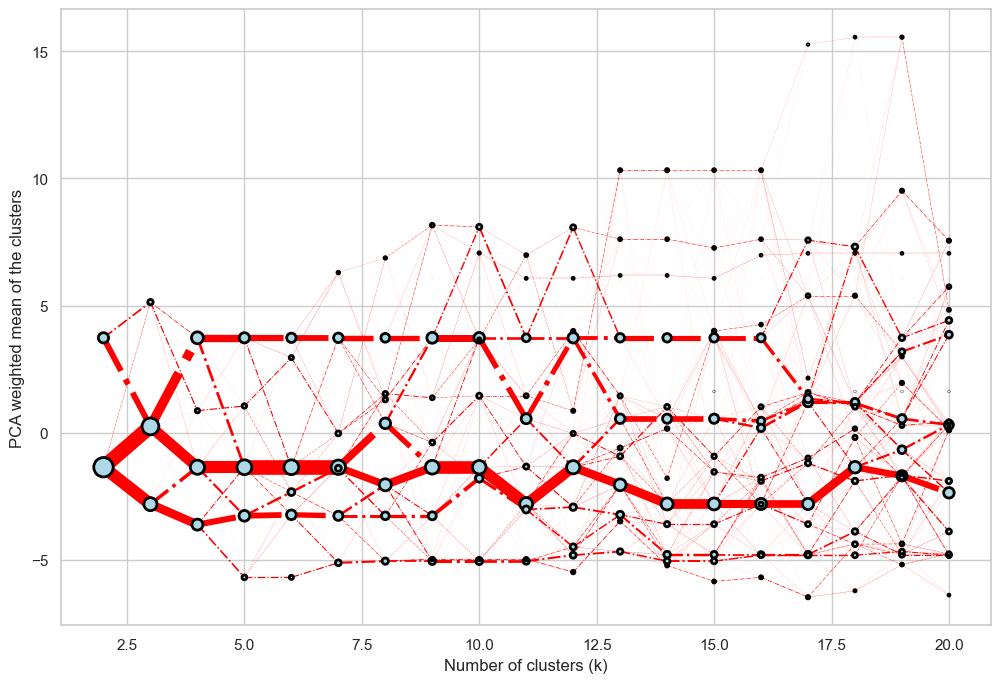

In [114]:
# plot cgram
sb.set(style='whitegrid')

cgram_gmm.plot(
    size=0.5,
    linewidth=0.5,
    cluster_style={"color": "lightblue", "edgecolor": "black"},
    line_style={"color": "red", "linestyle": "-."},
    figsize=(12, 8)
)

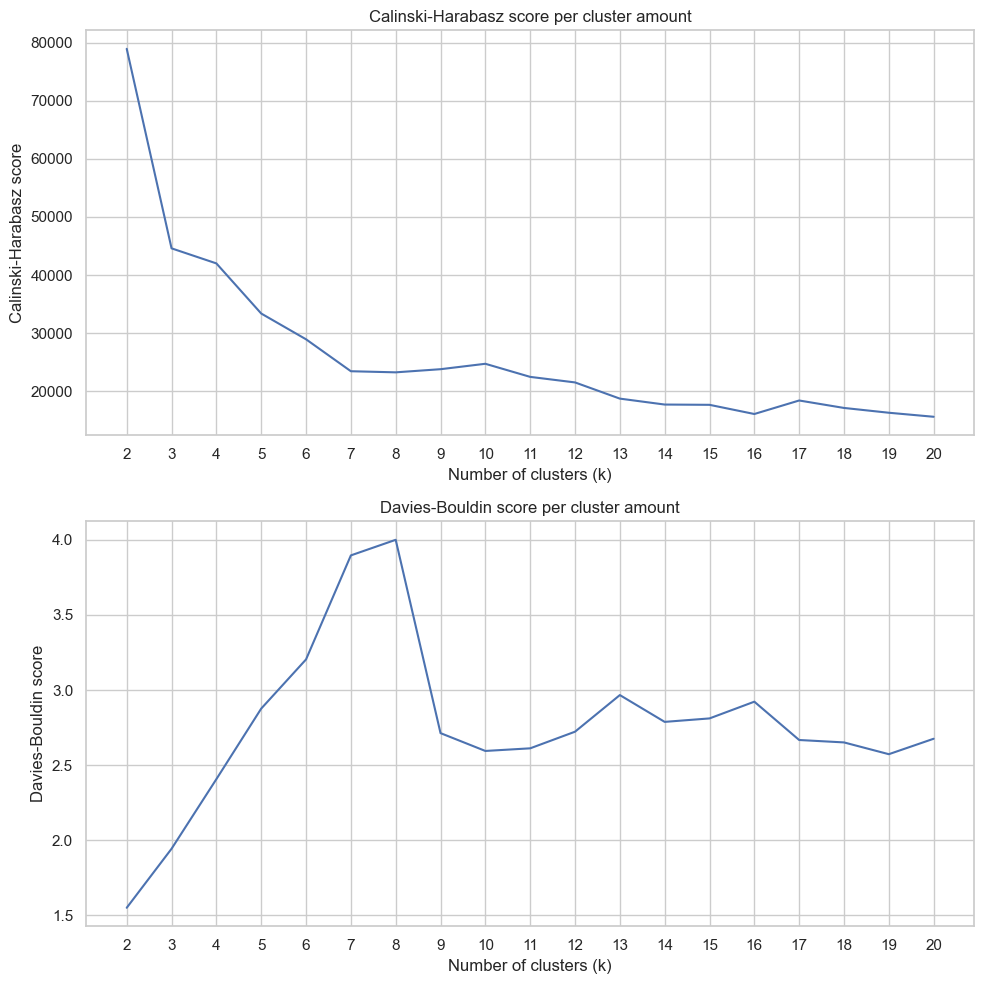

In [115]:
# Goodness of fit tests for the amount of clusters
# We use the Silhouette and Calinski-Harabasz scores, higher is better for both

# Calinski-Harabasz score: the within-cluster variance divided by the between-cluster variance.
# Davies-Bouldin score: The score is defined as the average similarity measure of each cluster with its most similar cluster, 
#  where similarity is the ratio of within-cluster distances to between-cluster distances. 
#  Thus, clusters which are farther apart and less dispersed will result in a better score.

# getting the scores
gmmch = cgram_gmm.calinski_harabasz_score()
gmmdb = cgram_gmm.davies_bouldin_score()

# Plotting both the Silhouette score and the Calinski-Harabasz score per cluster amount
fig, axs = plt.subplots(2, figsize=(10, 10))
axs[0].plot(K, gmmch)
axs[0].set_xlabel("Number of clusters (k)")
axs[0].set_ylabel("Calinski-Harabasz score")
axs[0].grid(True)
axs[0].set_xticks(range(2,21))
axs[0].set_title('Calinski-Harabasz score per cluster amount')
axs[1].plot(K, gmmdb)
axs[1].set_xlabel("Number of clusters (k)")
axs[1].set_ylabel("Davies-Bouldin score")
axs[1].grid(True)
axs[1].set_xticks(range(2,21))
axs[1].set_title('Davies-Bouldin score per cluster amount')
plt.tight_layout()
plt.show()

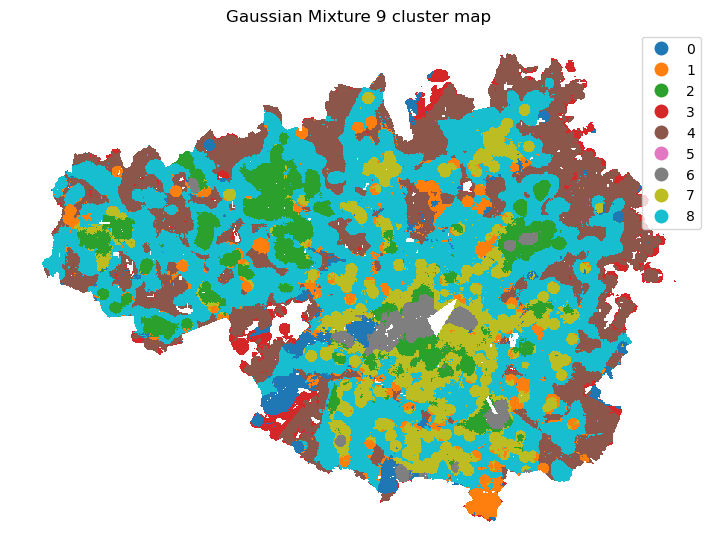

In [6]:
# Plotting results, 9 clusters
popgridsub["GMM_cluster_label"] = cgram_gmm.labels[9]
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
popgridsub.plot(
    column="GMM_cluster_label",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.title("Gaussian Mixture 9 cluster map")
plt.show()

In [137]:
# save cgrams
with open('clustergram_kmeans.pickle','wb') as f:
    pickle.dump(cgram_kmeans, f)

with open('clustergram_gmm.pickle','wb') as f:
    pickle.dump(cgram_gmm, f)

### Relationship between clusters and health outcomes

In [7]:
# subset of popgridsub to only contain the cluster labels and geometry
popgridsubsub = popgridsub[["Kmeans_cluster_label", "GMM_cluster_label", "geometry"]]

In [34]:
# subset of popgridsub to only contain the relevant health variables
healthdatasub = healthdata[["ID", "Yrpotlife", "Comilldis", "Obes_Per_Obesprev_y15", "Asthma_Per_Asthmaprev_y17", "Cancer_Per_cancerPrev_y17", "geometry"]]

In [35]:
# spatial join
joined_data = gpd.sjoin(healthdatasub, popgridsubsub, how='left', predicate='intersects')

# calculating the most common cluster label for each neighborhood and for both cluster models
majority_cluster_kmeans = joined_data.groupby('ID')['Kmeans_cluster_label'].apply(lambda x: x.mode())
majority_cluster_gmm = joined_data.groupby('ID')['GMM_cluster_label'].apply(lambda x: x.mode())

# calculating the diversity of the labels using Shannon entropy
def calculate_entropy(labels):
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    proportions = label_counts / label_counts.sum()
    entropy = -np.sum(proportions * np.log2(proportions))
    return entropy

# apply function
cluster_diversity_kmeans = joined_data.groupby('ID')['Kmeans_cluster_label'].apply(calculate_entropy)
cluster_diversity_gmm = joined_data.groupby('ID')['GMM_cluster_label'].apply(calculate_entropy)

# merging the cluster majority and cluster diversity
healthdatasub = healthdatasub.merge(majority_cluster_kmeans, on='ID')
healthdatasub = healthdatasub.merge(majority_cluster_gmm, on='ID')
healthdatasub = healthdatasub.merge(cluster_diversity_kmeans, on='ID')
healthdatasub = healthdatasub.merge(cluster_diversity_gmm, on='ID')

# renaming
healthdatasub = healthdatasub.rename(columns={'Kmeans_cluster_label_x': 'Majority_cluster_kmeans', 'GMM_cluster_label_x': 'Majority_cluster_gmm', 'Kmeans_cluster_label_y': 'cluster_diversity_kmeans', 'GMM_cluster_label_y': 'cluster_diversity_gmm'})

In [36]:
# Checking
healthdatasub.head(5)

,ID,Yrpotlife,Comilldis,Obes_Per_Obesprev_y15,Asthma_Per_Asthmaprev_y17,Cancer_Per_cancerPrev_y17,geometry,Majority_cluster_kmeans,Majority_cluster_gmm,cluster_diversity_kmeans,cluster_diversity_gmm
0,1,73.298,139.960,8.883782,6.428479,2.308713,"MULTIPOLYGON (((371172.854 411677.763, 371171....",2.0,2.0,1.175623,0.962664
1,2,70.453,122.767,8.775058,6.445275,2.324005,"MULTIPOLYGON (((371710.608 411870.891, 371719....",2.0,2.0,0.351955,0.848999
2,3,60.683,87.251,8.348821,6.483869,2.521615,"MULTIPOLYGON (((371146.001 413306.000, 371154....",1.0,4.0,1.628133,1.102350
3,4,66.842,101.857,8.538339,6.517075,2.487377,"MULTIPOLYGON (((371628.421 413041.967, 371623....",2.0,2.0,0.562747,0.993171
4,5,59.963,96.842,8.621558,6.501532,2.383783,"MULTIPOLYGON (((372209.845 412244.211, 372253....",8.0,8.0,1.101295,0.798739


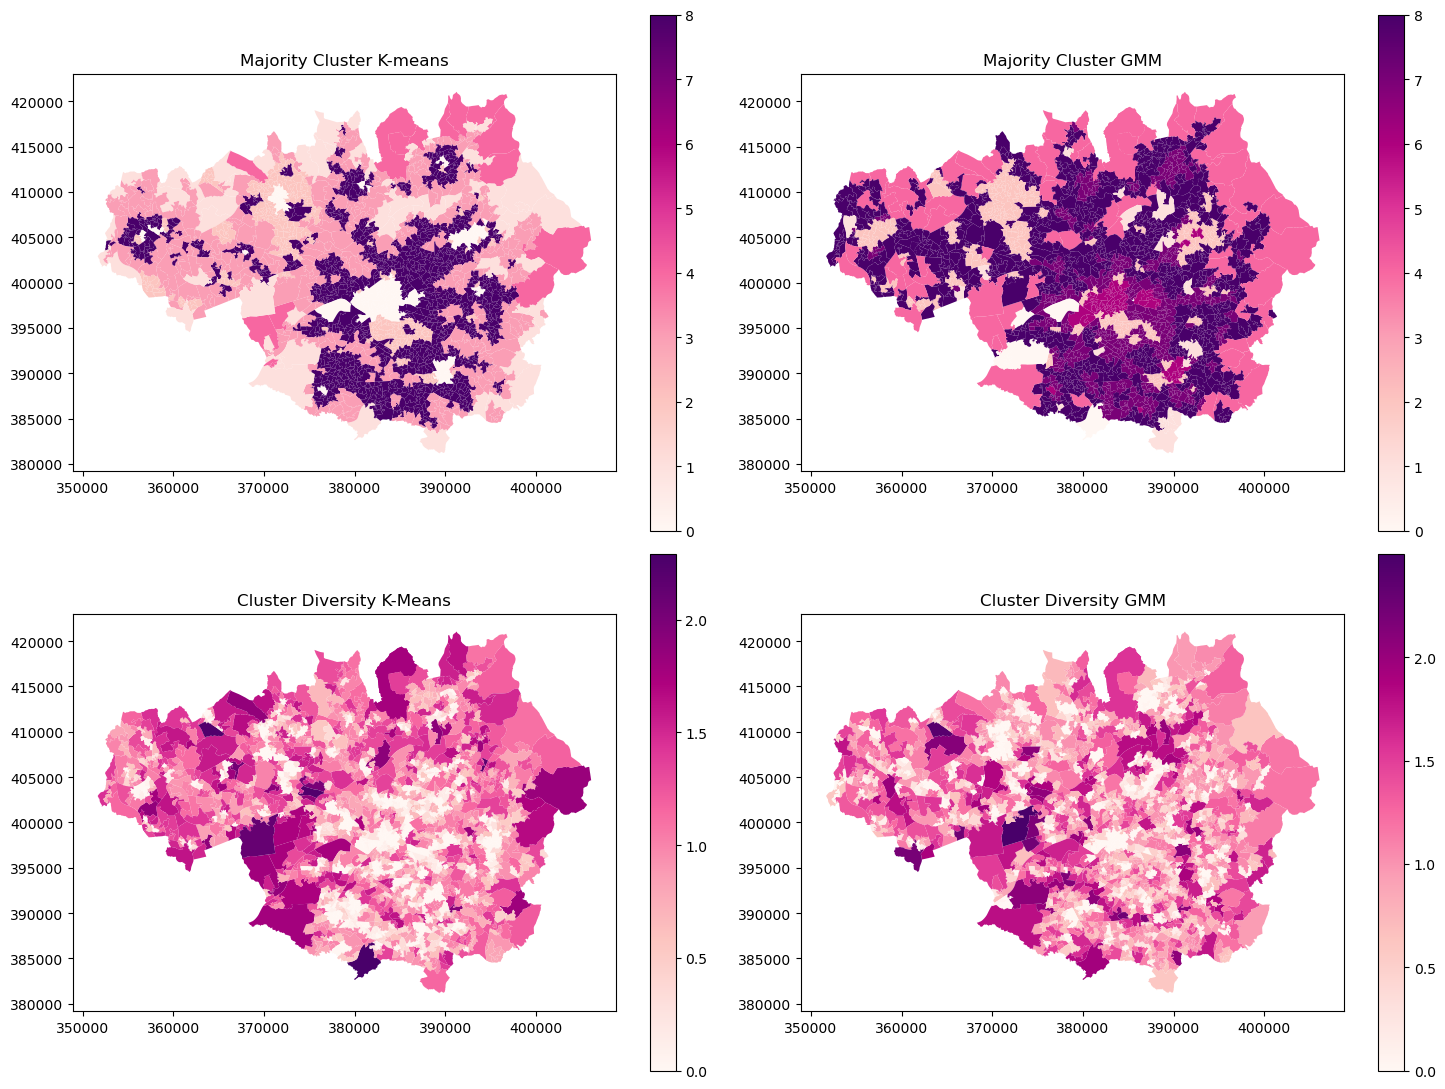

In [40]:
# Plotting the majority and diversity variables

fig, axs = plt.subplots(2, 2, figsize=(15,11))
healthdatasub.plot(column='Majority_cluster_kmeans', ax=axs[0,0],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[0,0].set_title("Majority Cluster K-means")
healthdatasub.plot(column='Majority_cluster_gmm', ax=axs[0,1],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[0,1].set_title("Majority Cluster GMM")
healthdatasub.plot(column='cluster_diversity_kmeans', ax=axs[1,0],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[1,0].set_title("Cluster Diversity K-Means")
healthdatasub.plot(column='cluster_diversity_gmm', ax=axs[1,1],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[1,1].set_title("Cluster Diversity GMM")

ax.set_axis_off()
plt.tight_layout()

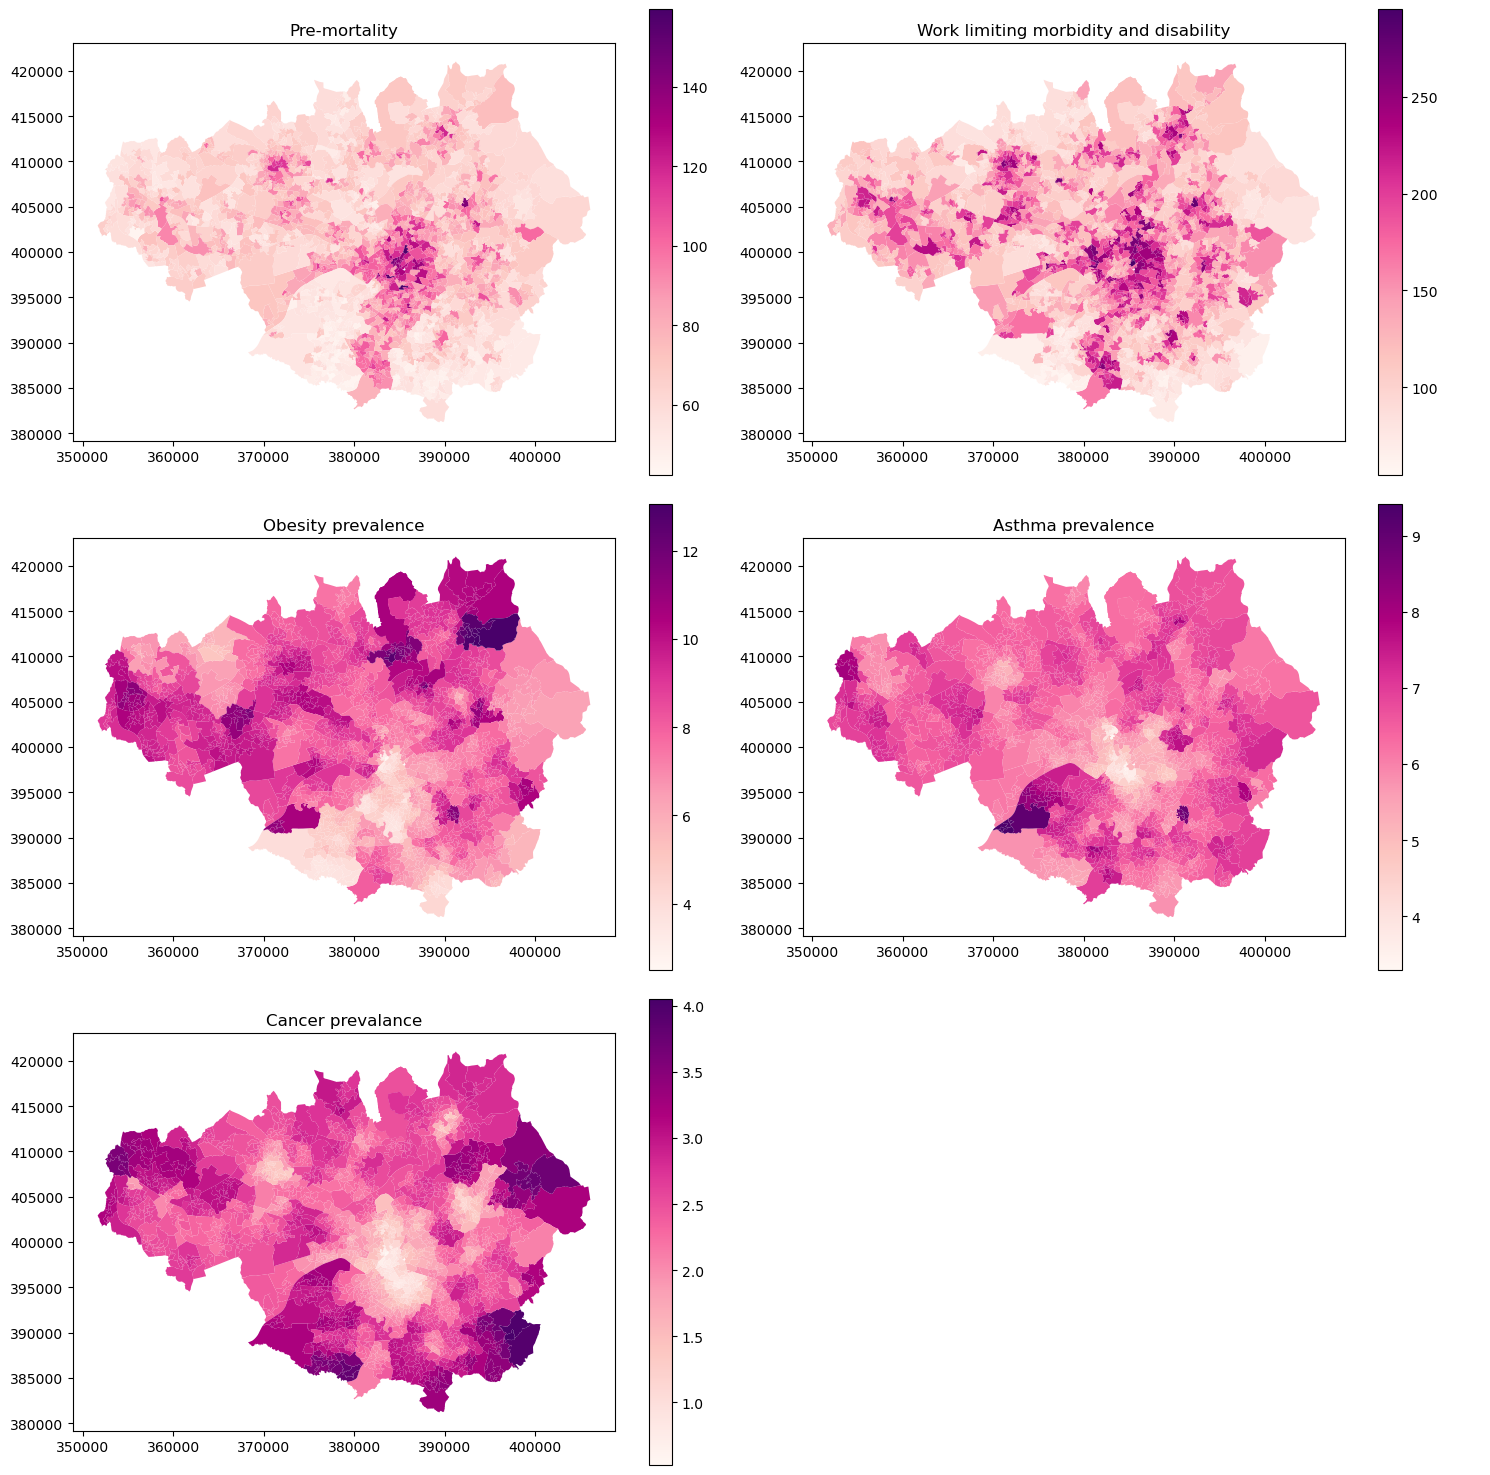

In [42]:
# Plotting health variables

fig, axs = plt.subplots(3, 2, figsize=(15,15))
healthdatasub.plot(column='Yrpotlife', ax=axs[0,0],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[0,0].set_title("Pre-mortality")
healthdatasub.plot(column='Comilldis', ax=axs[0,1],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[0,1].set_title("Work limiting morbidity and disability")
healthdatasub.plot(column='Obes_Per_Obesprev_y15', ax=axs[1,0],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[1,0].set_title("Obesity prevalence")
healthdatasub.plot(column='Asthma_Per_Asthmaprev_y17', ax=axs[1,1],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[1,1].set_title("Asthma prevalence")
healthdatasub.plot(column='Cancer_Per_cancerPrev_y17', ax=axs[2,0],
        linewidth=0,
        cmap="RdPu",
        legend=True)
axs[2,0].set_title("Cancer prevalance")

# Removing last empty one
axs[2,1].axis('off')

plt.tight_layout()

<AxesSubplot: >

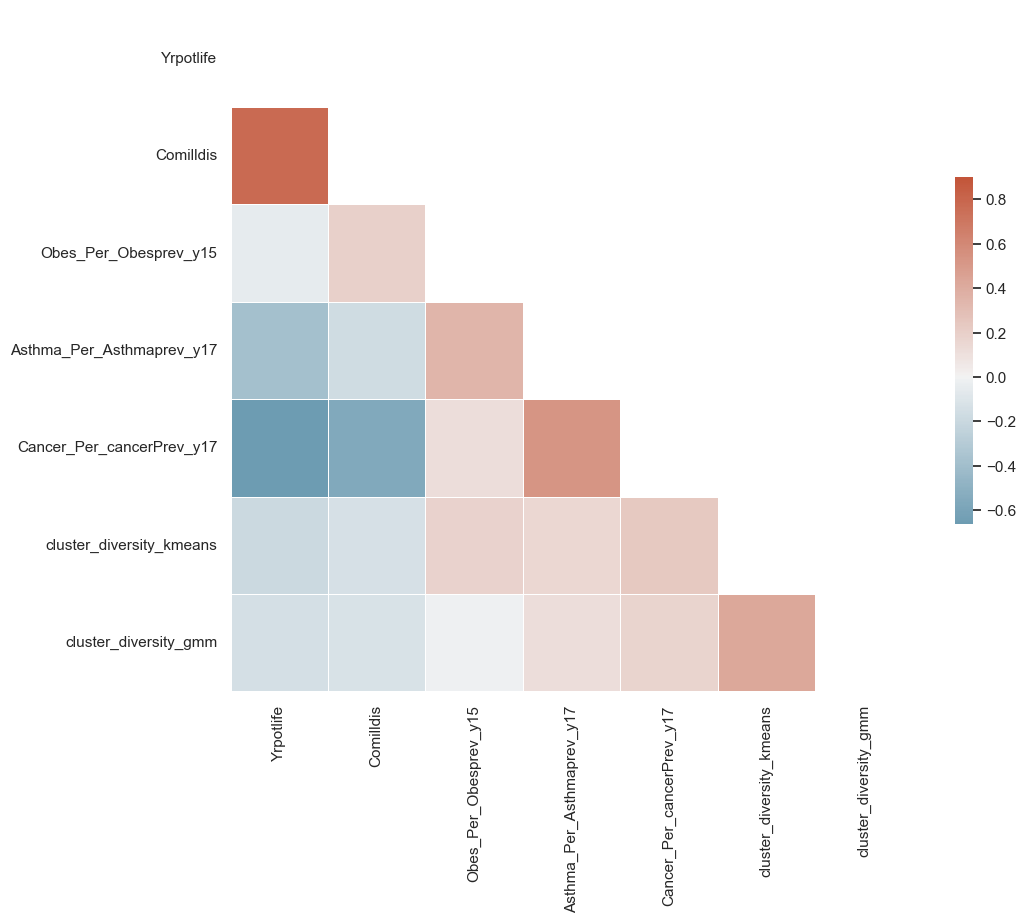

In [43]:
# correlation matrix of the variables but not the majority variable due to it being nominal
sb.set_theme(style="white")

# Compute the correlation matrix
corr = healthdatasub[["Yrpotlife", "Comilldis", "Obes_Per_Obesprev_y15", "Asthma_Per_Asthmaprev_y17", "Cancer_Per_cancerPrev_y17", "cluster_diversity_kmeans", "cluster_diversity_gmm"]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [46]:
# kruskal-wallis test for the nominal cluster majority variable to see if the distributions of the health outcomes
# differ for each cluster majoirty value

# grouped variable
clustermajority_kmeans = healthdatasub.groupby('Majority_cluster_kmeans')
clustermajority_gmm = healthdatasub.groupby('Majority_cluster_gmm')

# health outcomes
health_outcomes = ["Yrpotlife", "Comilldis", "Obes_Per_Obesprev_y15", "Asthma_Per_Asthmaprev_y17", "Cancer_Per_cancerPrev_y17"]

# kruskal-wallis test for each of the health variables with the cluster majority variable
for x in health_outcomes:
    # for each cluster (K-means)
    data = [group[x].values for _, group in clustermajority_kmeans]
    # kruskal-wallis test
    stat, p = kruskal(*data)
    print('K-means:  Variable: {0:15s}  Statistics={1:<10.3f}  p={2:<10.3f}'.format(x, stat, p))
    # for each cluster (GMM)
    data = [group[x].values for _, group in clustermajority_gmm]
    # kruskal-wallis test
    stat, p = kruskal(*data)
    print('GMM:      Variable: {0:15s}  Statistics={1:<10.3f}  p={2:<10.3f}'.format(x, stat, p))

K-means:  Variable: Yrpotlife        Statistics=255.145     p=0.000     
GMM:      Variable: Yrpotlife        Statistics=221.911     p=0.000     
K-means:  Variable: Comilldis        Statistics=192.194     p=0.000     
GMM:      Variable: Comilldis        Statistics=204.455     p=0.000     
K-means:  Variable: Obes_Per_Obesprev_y15  Statistics=56.115      p=0.000     
GMM:      Variable: Obes_Per_Obesprev_y15  Statistics=143.252     p=0.000     
K-means:  Variable: Asthma_Per_Asthmaprev_y17  Statistics=116.664     p=0.000     
GMM:      Variable: Asthma_Per_Asthmaprev_y17  Statistics=112.886     p=0.000     
K-means:  Variable: Cancer_Per_cancerPrev_y17  Statistics=351.392     p=0.000     
GMM:      Variable: Cancer_Per_cancerPrev_y17  Statistics=324.451     p=0.000     


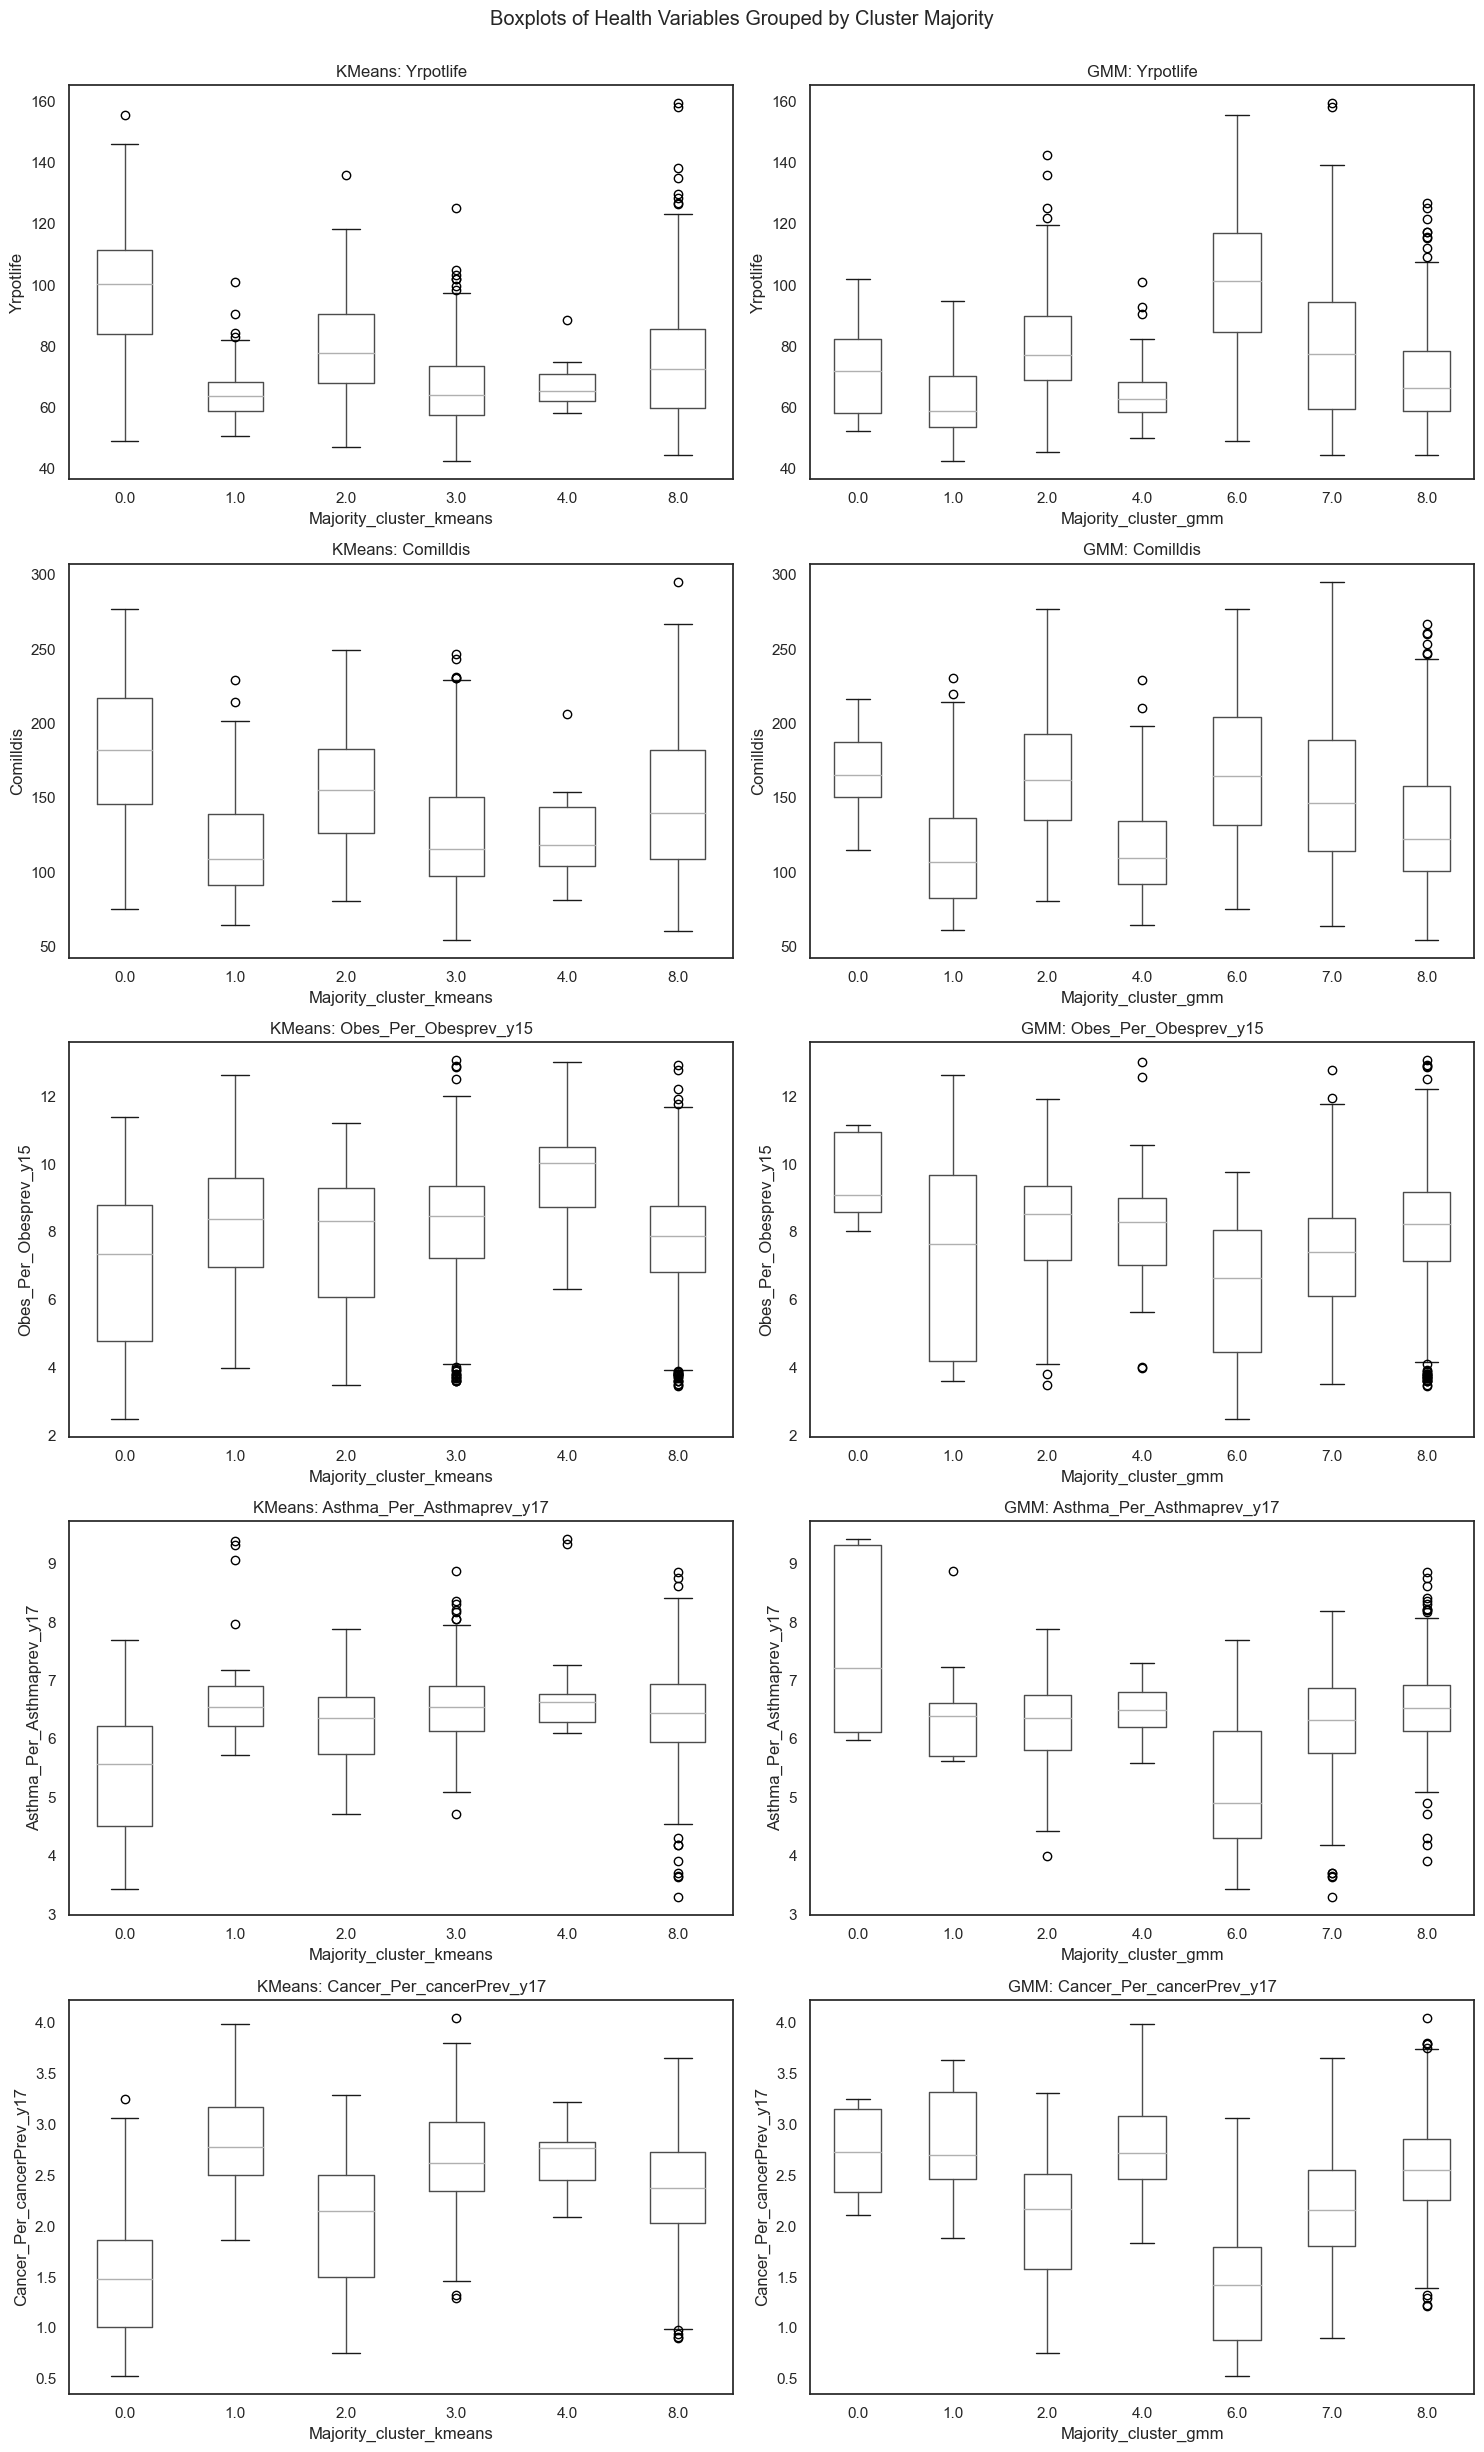

In [47]:
# boxplots to show the distributions of the health variables per clustr majority value

fig, axs = plt.subplots(len(health_outcomes), 2, figsize=(15, 5*len(health_outcomes)))
for i, x in enumerate(health_outcomes):
    # for k-means
    healthdatasub.boxplot(column=x, by='Majority_cluster_kmeans', grid=False, ax=axs[i, 0])
    axs[i, 0].set_title(f'KMeans: {x}')
    axs[i, 0].set_xlabel('Majority_cluster_kmeans')
    axs[i, 0].set_ylabel(x)
    # for gmm too
    healthdatasub.boxplot(column=x, by='Majority_cluster_gmm', grid=False, ax=axs[i, 1])
    axs[i, 1].set_title(f'GMM: {x}')
    axs[i, 1].set_xlabel('Majority_cluster_gmm')
    axs[i, 1].set_ylabel(x)

plt.suptitle('Boxplots of Health Variables Grouped by Cluster Majority')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

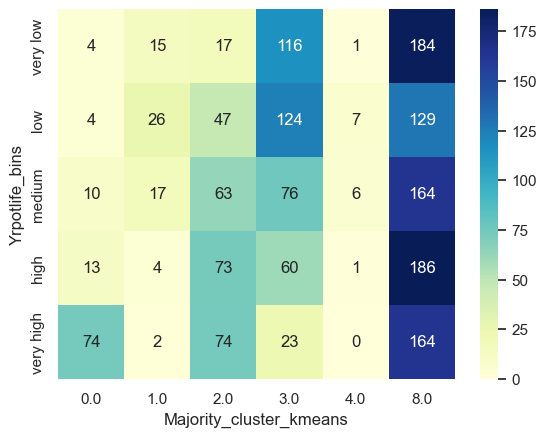

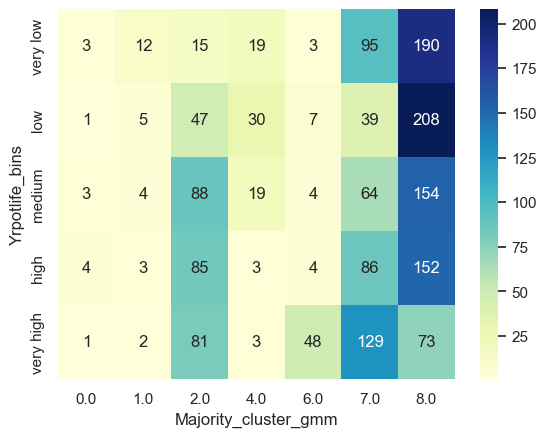

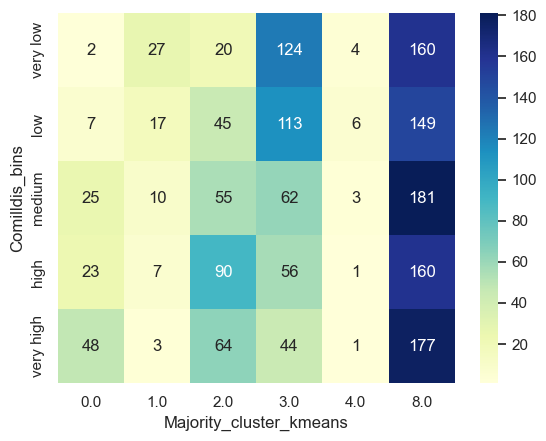

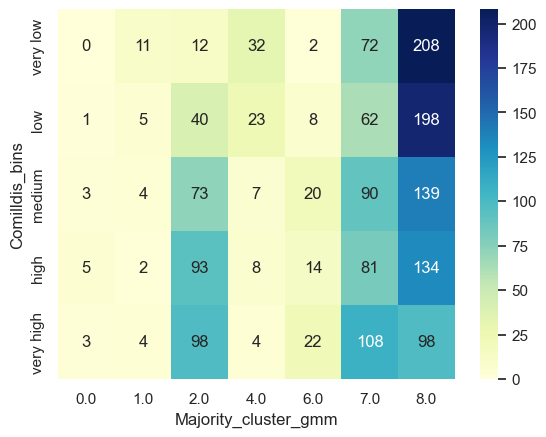

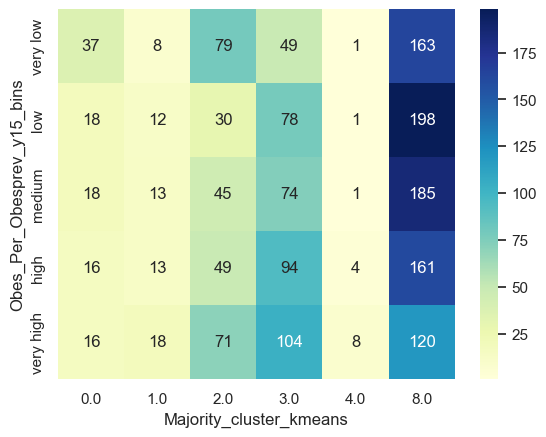

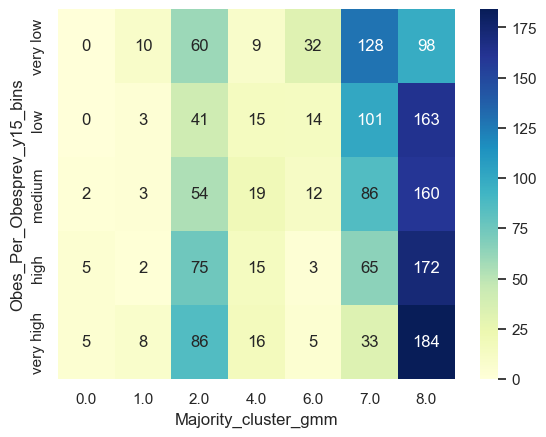

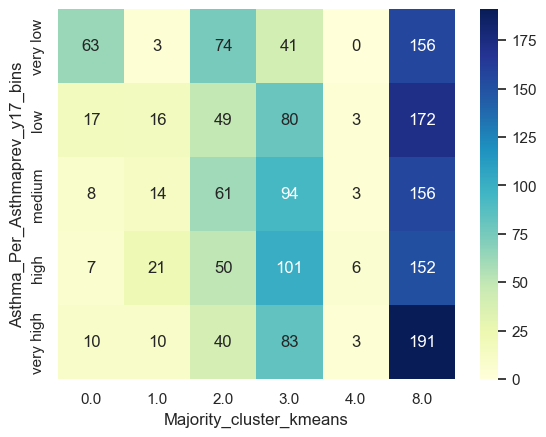

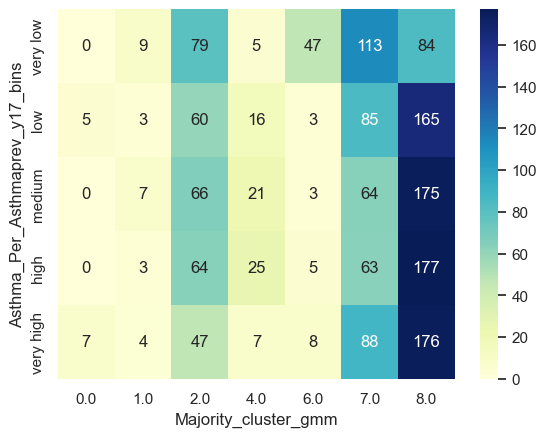

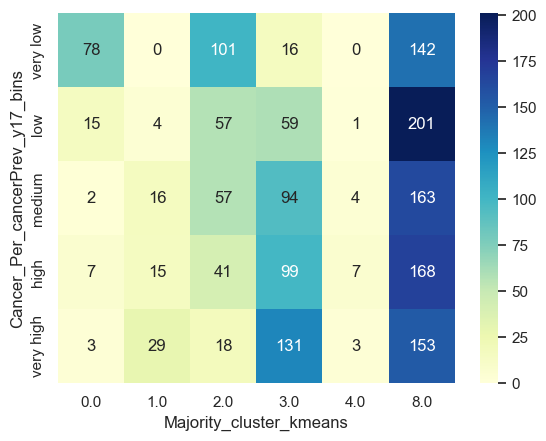

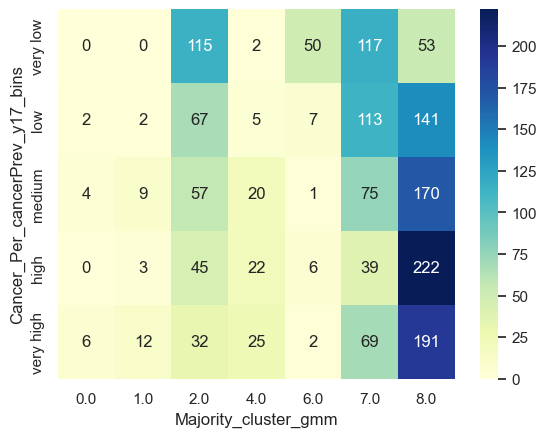

In [50]:
# contigency tables for further visualization of the cluster majority and health data relationship

# health variables
health_outcomes = ["Yrpotlife", "Comilldis", "Obes_Per_Obesprev_y15", "Asthma_Per_Asthmaprev_y17", "Cancer_Per_cancerPrev_y17"]

# loop over the health outcomes to cut the health variables into 5 bins and create the contingency table
for x in health_outcomes:
    # cut into 5 bins
    healthdatasub[f'{x}_bins'] = pd.qcut(healthdatasub[x], q=5, labels=['very low', 'low', 'medium', 'high', 'very high'])
    # contingency table for the health outcome and cluster majority values
    contingency_table = pd.crosstab(healthdatasub[f'{x}_bins'], healthdatasub['Majority_cluster_kmeans'])
    sb.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='.0f')
    plt.show()
    contingency_table = pd.crosstab(healthdatasub[f'{x}_bins'], healthdatasub['Majority_cluster_gmm'])
    sb.heatmap(contingency_table, annot=True, cmap='YlGnBu', fmt='.0f')
    plt.show()